In [1]:
# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline 

import os
import scipy.io
import numpy as np
import statistics, math
import matplotlib.pyplot as plt
from libs import util_matlab as umatlab
from libs import datasets, dataset_utils, utils
import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell


plt.style.use('ggplot')

In [873]:
useMFCCs = 1
if useMFCCs:
    data_dir="/Users/alfonso/matlab/IndirectAcquisition/keras/dataWithMFCCs"
else:
    #data_dir="/Users/alfonso/matlab/IndirectAcquisition/keras/dataforMarius/export"
    data_dir = '/Users/alfonso/matlab/IndirectAcquisition/keras/dataWith40Bands_hop256' #dataWith40Bands'
files = [os.path.join(data_dir, file_i) for file_i in os.listdir(data_dir) if file_i.endswith('.mat')]

In [874]:
filename= files[77]
print('reading file: ', filename)
matlabStruct=umatlab.loadmat(filename).get('data')
if useMFCCs:
    input_features = matlabStruct.get('melcoef_labrosa') 
    totalSecs = matlabStruct.get('totalSecs')
    control_sr = matlabStruct.get('controlSR')
    #input_sr = matlabStruct.get('energyFeaturesSR')
else:
    input_features=matlabStruct.get('energyBand')
    input_features=(input_features /120 )+1 #normalize [0-1]
    #totalSecs=matlabStruct.get('waveIn').shape[0]/matlabStruct.get('audioSR')
    totalSecs = matlabStruct.get('totalSecs')
    control_sr=matlabStruct.get('controlSR') #240 #energyBand.shape[1]/totalSecs #This is around 240Hz- around 5ms at 44100Hz

controlNames=matlabStruct.get('controlNames')
controlData=matlabStruct.get('controlData')
indexAbsVel=[i for i in range(controlNames.shape[0]) if controlNames[i] == 'abs(velocity)'][0]
#indexVel=[i for i in range(controlNames.shape[0]) if controlNames[i] == 'velocity'][0]
indexForce=[i for i in range(controlNames.shape[0]) if controlNames[i] == 'forceN'][0]
velocity=controlData[indexAbsVel,:]/150
force=(controlData[indexForce,:]+0.2)/2
#indexString=[i for i in range(controlNames.shape[0]) if controlNames[i] == 'string'][0]
#string=controlData[indexString,:]
#pitch=controlData[6,:]/1500
    
# We want winLSecs seconds of audio in our window
winLSecs=0.05
windowSize=int((winLSecs*control_sr)//2*2)
# And we'll move our window by windowSize/2
hopSize=windowSize//2
n_input_features = input_features.shape[0]
n_hops = (input_features.shape[1]) // hopSize
print('windowSize:', windowSize, ', hopSize:', hopSize)

reading file:  /Users/alfonso/matlab/IndirectAcquisition/keras/dataWithMFCCs/phrase_27b_ff.mat
windowSize: 12 , hopSize: 6


In [875]:
controlNames

array(['string', 'abs(velocity)', 'forceN', 'velocity', 'acc(abs(vel)',
       'tilt', 'bbd', 'pitch'], dtype=object)

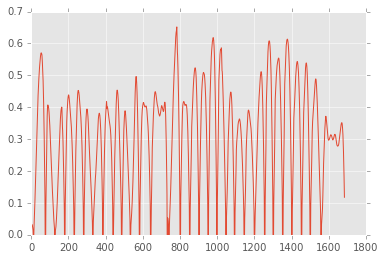

In [876]:
plt.plot(velocity)

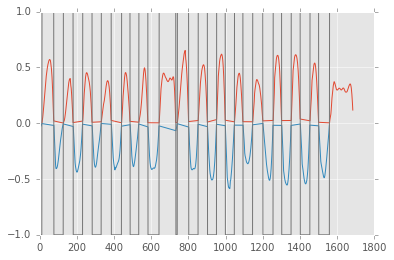

In [638]:
upbowIdx=np.where(velocity>0)
downBowIdx=np.where(velocity<0)
bowChangeIdx=np.where(velocity==0)
upbowIdx = np.squeeze(np.array(upbow))
downBowIdx = np.squeeze(np.array(downBow))
bowChangeIdx = np.squeeze(np.array(bowChangeIdx))
plt.plot(upbowIdx, velocity[upbowIdx])
plt.plot(downBowIdx, velocity[downBowIdx])
plt.plot(bowChangeIdx, velocity[bowChangeIdx])
bowDir=np.zeros(len(velocity))
bowDir[upbowIdx] = 1
bowDir[downBowIdx] = -1
bowDir[bowChangeIdx] = 0
plt.plot(bowDir)

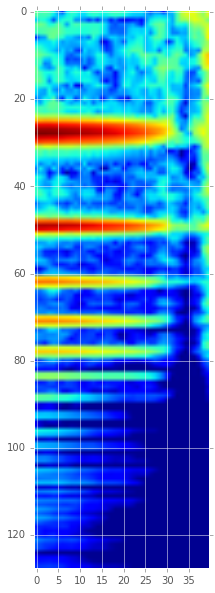

In [513]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(input_features[:,100:140])

In [877]:
Xs = []
ys = []
doVelWithSign = 0
# Let's start with the music files
for filename in files:
    #print(filename)
    matlabStruct=umatlab.loadmat(filename).get('data')
    controlData=matlabStruct.get('controlData')
    controlNames=matlabStruct.get('controlNames')
    if doVelWithSign:
        target=controlData[indexVel,:]/150
        #target=(controlData[indexForce,:]+0.2)/2
        upbowIdx=np.where(target>0)
        downBowIdx=np.where(target<0)
        bowChangeIdx=np.where(target==0)
        upbowIdx = np.squeeze(np.array(upbowIdx))
        downBowIdx = np.squeeze(np.array(downBowIdx))
        bowChangeIdx = np.squeeze(np.array(bowChangeIdx))
        bowDir=np.zeros(len(target))
        bowDir[upbowIdx] = 1
        bowDir[downBowIdx] = -1
        bowDir[bowChangeIdx] = 0
    else:
        target=controlData[indexAbsVel,:]/150
        
    
    if useMFCCs:
        input_features = matlabStruct.get('melcoef_labrosa') 
        totalSecs = matlabStruct.get('totalSecs')
        #control_sr = matlabStruct.get('controlSR')
        #input_sr = matlabStruct.get('energyFeaturesSR')
    else:
        input_features=matlabStruct.get('energyBand')
        input_features=(input_features /120 )+1 #normalize [0-1]
        totalSecs = matlabStruct.get('totalSecs')
        #totalSecs=matlabStruct.get('waveIn').shape[0]/matlabStruct.get('audioSR')
        #control_sr=matlabStruct.get('controlSR') #240 #energyBand.shape[1]/totalSecs #This is around 240Hz- around 5ms at 44100Hz



    n_hops = (input_features.shape[1]) // hopSize
    
    #print(n_frames_per_second, n_frames, frame_hops, n_hops)
    n_hops=int(n_hops)-1
    for hop_i in range(n_hops):
        # Creating our sliding window
        frames = input_features[:,(hop_i * hopSize):(hop_i * hopSize + windowSize)]
        if doVelWithSign:
            sign_frame=bowDir[(hop_i * hopSize):(hop_i * hopSize + windowSize)]
            frames=np.vstack([frames, sign_frame])
        Xs.append(frames[..., np.newaxis])
        # And then store the vel 
        ys.append(target[(hop_i * hopSize):(hop_i * hopSize + windowSize)])

Xs = np.array(Xs)
ys = np.array(ys)
print(Xs.shape, ys.shape)

(94605, 128, 12, 1) (94605, 12)


In [878]:
n_observations, n_height, n_width, n_channels = Xs.shape

In [918]:
np.min(input_features)

-81.874341274333048

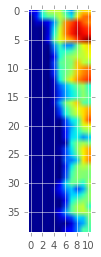

In [879]:
plt.imshow(Xs[1,1:40,1:18,0])

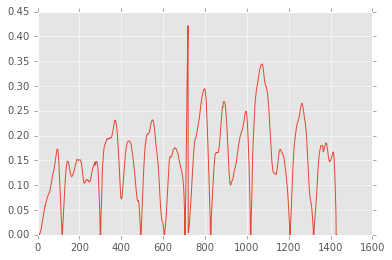

In [880]:
plt.plot(target)

In [881]:
ds = datasets.Dataset(Xs=Xs, ys=ys, split=[0.8, 0.1, 0.1], n_classes=0)

In [882]:
Xs_i, ys_i = next(ds.train.next_batch())

# Notice the shape this returns.  This will become the shape of our input and output of the network:
print(Xs_i.shape, ys_i.shape)

(100, 128, 12, 1) (100, 12)


In [906]:
tf.reset_default_graph()
print(Xs_i.shape)
# Create the input to the network.  This is a 4-dimensional tensor (batch_size, height(freq), widht(time), channels?)!
# Recall that we are using sliding windows of our magnitudes (TODO):
X = tf.placeholder(name='X', shape=(None,Xs.shape[1],Xs.shape[2],Xs.shape[3]), dtype=tf.float32)

# Create the output to the network.  This is our one hot encoding of 2 possible values (TODO)!
Y = tf.placeholder(name='Y', shape=(None,windowSize), dtype=tf.float32)

# TODO:  Explore different numbers of layers, and sizes of the network
n_filters = [30, 30, 30] #[30, 30] 
filters_height = [2, 2, 2]  #MFCC[5, 5, 5] #[n_input_features, 1] 
filters_width = [2, 2, 2]   #MFCC[2, 2, 2] #[1, windowSize] 
filters_stride_h = [2, 2, 2]  #MFCC[3, 3, 3] #[1, 1]
filters_stride_w = [1, 1, 1]  #MFCC[1, 1, 1] #[1, 1] 
padding='VALID'

# Now let's loop over our n_filters and create the deep convolutional neural network
H = X
for layer_i, n_filters_i in enumerate(n_filters):
    
    # Let's use the helper function to create our connection to the next layer:
    # TODO: explore changing the parameters here:
    H, W = utils.conv2d(
        H, n_filters_i, k_h=filters_height[layer_i], k_w=filters_width[layer_i],
        d_h=filters_stride_h[layer_i], d_w=filters_stride_w[layer_i],
        name=str(layer_i), padding=padding)
    
    # And use a nonlinearity
    # TODO: explore changing the activation here:
    H = tf.nn.softplus(H)
    
    # Just to check what's happening:
    print(H.get_shape().as_list())

(140, 128, 12, 1)
[None, 64, 11, 30]
[None, 32, 10, 30]
[None, 16, 9, 30]


In [907]:
# LSTM_ Prepare output of convNet as input to LSTM
[batch_size, n_inputs, time_seq, n_filters] = H.get_shape().as_list()
print("0:", [batch_size, n_inputs, time_seq, n_filters])
doLSTM = 1
if doLSTM:
    #Input is of the shape(batch, inputs, time, filters)
    #First transpose to (time, batch, inputs, filters)
    hs = tf.transpose(H, [2, 0, 1, 3])
    print("1:", hs.get_shape().as_list())
    #Then join inputs*filters as inputs. Shape(time, batch, inputs*filters)
    n_inputs_lstm = n_inputs * n_filters
    hs = tf.reshape(hs,shape=[time_seq, -1, n_inputs_lstm])  #flatten
    print("2:", hs.get_shape().as_list())
    #Then, join time*batch_size
    hs = tf.reshape(hs,shape=[-1, n_inputs_lstm])
    print("3:", hs.get_shape().as_list())
    #Finally, Split to get a list of 'time_seq' tensors of shape (batch_size, n_inputs*n_filters)
    hs = tf.split(0, time_seq, hs)
    print("4:", np.array(hs).shape)
else:
    outputs=H    


0: [None, 16, 9, 30]
1: [9, None, 16, 30]
2: [9, None, 480]
3: [None, 480]
4: (9,)


In [908]:
if doLSTM:
    # Number of cells in our LSTM layer
    n_cells = 10

    # Number of LSTM layers
    n_layers = 1

    if n_layers > 1:
        cells = tf.nn.rnn_cell.MultiRNNCell(
            [cells] * n_layers, state_is_tuple=True)
        initial_state = cells.zero_state(tf.shape(X)[0], tf.float32)
    else:
        cells = tf.nn.rnn_cell.BasicLSTMCell(num_units=n_cells, state_is_tuple=True, forget_bias=1.0)
        #initial_state = cells.zero_state(tf.shape(X)[0], tf.float32)
        
if doLSTM:
    # this will return us a list of outputs of every element in our sequence.
    # Each output is `batch_size` x `n_cells` of output.
    # It will also return the state as a tuple of the n_cells's memory and
    # their output to connect to the time we use the recurrent layer.
    #outputs, state = tf.nn.rnn(cells, hs, initial_state=initial_state)
    #print(outputs)

    # Get lstm cell output
    outputs, states = rnn.rnn(cells, hs, dtype=tf.float32)
    #print(outputs.get_shape().as_list())
    # Linear activation, using rnn inner loop last output
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([n_cells, time_seq]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([time_seq]))
    }
    outputs= tf.matmul(outputs[-1], weights['out']) + biases['out']
    outputs.get_shape().as_list()

In [909]:
# Connect the last convolutional layer to a fully connected network
fc1, W = utils.linear(outputs, n_output=100, name="fcn1", activation=tf.nn.relu)
fc2, W = utils.linear(fc1, n_output=50, name="fcn2", activation=tf.nn.relu)
fc3, W = utils.linear(fc2, n_output=10, name="fcn3", activation=tf.nn.relu)


# And another fully connceted network, now with just n_classes outputs, the number of outputs
Y_pred, W = utils.linear(fc3, n_output=windowSize, name="pred", activation=tf.nn.sigmoid)


#To reduce overfitting, we will apply dropout before the readout layer. 
#We create a placeholder for the probability that a neuron's output is kept during dropout. 
#This allows us to turn dropout on during training, and turn it off during testing. 
#TensorFlow's tf.nn.dropout op automatically handles scaling neuron outputs in addition to masking them, 
#so dropout just works without any additional scaling.
#keep_prob = tf.placeholder("float")
#fc1_drop = tf.nn.dropout(fc1, keep_prob)
#Y_pred, W = utils.linear(fc1_drop, n_output=windowSize, name="pred", activation=tf.nn.sigmoid)

In [910]:
loss = tf.squared_difference(Y_pred,Y)
cost = tf.reduce_mean(tf.reduce_sum(loss, 1))
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Explore these parameters: (TODO)
batch_size = 400
# Create a session and init!
sess = tf.Session()
saver = tf.train.Saver()
sess.run(tf.initialize_all_variables())

In [912]:
# Now iterate over our dataset n_epoch times
n_epochs = 1000
for epoch_i in range(n_epochs):
    print('Epoch: ', epoch_i)
    
    # Train
    this_cost = 0
    its = 0
    
    # Do our mini batches:
    for Xs_i, ys_i in ds.train.next_batch(batch_size):
        # Note here: we are running the optimizer so
        # that the network parameters train!
        this_cost += sess.run([cost, optimizer], feed_dict={
                X:Xs_i, Y:ys_i})[0]
        its += 1
        #print(this_cost / its)
    print('Training cost: ', this_cost / its)
    
    # Validation (see how the network does on unseen data).
    this_cost = 0
    its = 0
    
    # Do our mini batches:
    for Xs_i, ys_i in ds.valid.next_batch(batch_size):
        # Note here: we are NOT running the optimizer!
        # we only measure the accuracy!
        this_cost += sess.run(cost, feed_dict={
                X:Xs_i, Y:ys_i}) #, keep_prob: 1.0
        its += 1
    print('Validation cost: ', this_cost / its)

Epoch:  0
Training cost:  0.60224974877
Validation cost:  0.268466704835
Epoch:  1
Training cost:  0.122458736598
Validation cost:  0.101502045058
Epoch:  2
Training cost:  0.0979939450951
Validation cost:  0.0955360913649
Epoch:  3
Training cost:  0.0947916110095
Validation cost:  0.0907321640601
Epoch:  4
Training cost:  0.0911572344993
Validation cost:  0.0974344275892
Epoch:  5
Training cost:  0.0887543266541
Validation cost:  0.0880857643982
Epoch:  6
Training cost:  0.0858698073971
Validation cost:  0.0864454073211
Epoch:  7
Training cost:  0.0830539325742
Validation cost:  0.0840889917066
Epoch:  8
Training cost:  0.0820984010045
Validation cost:  0.0834257074942
Epoch:  9
Training cost:  0.0798367921459
Validation cost:  0.0810014288872
Epoch:  10
Training cost:  0.0786054560032
Validation cost:  0.0779619573926
Epoch:  11
Training cost:  0.0775191507449
Validation cost:  0.0778771225984
Epoch:  12
Training cost:  0.0767446237959
Validation cost:  0.0764815754568
Epoch:  13
Tra

KeyboardInterrupt: 

In [ ]:
saver_def = saver.as_saver_def()
print(saver_def.restore_op_name)

In [ ]:
g = tf.get_default_graph()
[op.name for op in g.get_operations()]

In [ ]:
summary_writer = tf.train.SummaryWriter('log_simple_graph', sess.graph)

In [ ]:
g = tf.get_default_graph()
for layer_i in range(len(n_filters)):
    W = sess.run(g.get_tensor_by_name('{}/W:0'.format(layer_i)))
    print(W.shape)
    plt.figure(figsize=(5, 5))
    plt.imshow(utils.montage_filters(W))
    plt.title('Layer {}\'s Learned Convolution Kernels'.format(layer_i))

In [913]:
filename= files[77]
print('reading file: ', filename)
matlabStruct=umatlab.loadmat(filename).get('data')
if useMFCCs:
    input_features = matlabStruct.get('melcoef_labrosa')
else:
    input_features = matlabStruct.get('energyBand')
    input_features=(input_features /120 )+1
controlData=matlabStruct.get('controlData')

if doVelWithSign:
    target=controlData[indexVel,:]/150
    #target=(controlData[indexForce,:]+0.2)/2
    upbowIdx=np.where(target>0)
    downBowIdx=np.where(target<0)
    bowChangeIdx=np.where(target==0)
    upbowIdx = np.squeeze(np.array(upbowIdx))
    downBowIdx = np.squeeze(np.array(downBowIdx))
    bowChangeIdx = np.squeeze(np.array(bowChangeIdx))
    bowDir=np.zeros(len(target))
    bowDir[upbowIdx] = 1
    bowDir[downBowIdx] = -1
    bowDir[bowChangeIdx] = 0
else:
    target=controlData[indexAbsVel,:]/150

reading file:  /Users/alfonso/matlab/IndirectAcquisition/keras/dataWithMFCCs/phrase_27b_ff.mat


In [914]:
n_frames = input_features.shape[1]//windowSize
print('n_frames:', n_frames)
if doVelWithSign:
    Xs_i=np.zeros(shape=(n_frames,n_input_features+1,windowSize,1))
else: 
    Xs_i=np.zeros(shape=(n_frames,n_input_features,windowSize,1))
ys_i=np.zeros(shape=(n_frames,windowSize))

for i_frame in range(0, n_frames):
    frames = input_features[:,i_frame*windowSize:i_frame*windowSize+windowSize]
    ys_i[i_frame,:]=target[i_frame*windowSize:i_frame*windowSize+windowSize]
    if doVelWithSign:
        sign_frame=bowDir[(hop_i * hopSize):(hop_i * hopSize + windowSize)]
        frames=np.vstack([frames, sign_frame])
    Xs_i[i_frame,:,:,0] = frames        
prediction=sess.run([Y_pred], feed_dict={X:Xs_i})[0] #, keep_prob: 1.0
linPrediction = np.reshape(prediction, (np.product(prediction.shape)))
linOriginal = np.reshape(ys_i, (np.product(ys_i.shape)))
prediction.shape

n_frames: 140


(140, 12)

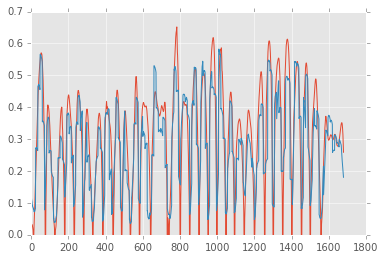

In [915]:
plt.plot(linOriginal)
plt.plot(linPrediction)
#plt.ylim((0, 0.6))

Now save the session with the Saver previously started variable.

In [916]:
import datetime
now = datetime.datetime.now()
save_path = saver.save(sess, "./models/velocity_convnet_MFCCs_hop128"+ now.strftime("%Y%m%d_%H%M") + ".ckpt")
print("Model saved in file: %s" % save_path)

Model saved in file: ./models/velocity_convnet_MFCCs_hop12820170606_1709.ckpt
